# Knowledge Graph Construction Pipeline

This notebook demonstrates the complete process of building a knowledge graph from raw text data. The pipeline includes:

1. Text collection through web scraping
2. Text preprocessing and cleaning
3. Named Entity Recognition (NER)
4. Relation Extraction (RE)
5. Knowledge Graph Construction
6. Visualization and querying

## Setup

First, let's import the necessary libraries and set up the environment.

In [17]:
# Import standard libraries
import os
import sys
import json
import logging
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [18]:
# Add project root to path for importing local modules
# Adjust this path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.data_collection.scraper import NewsArticleScraper
from src.preprocessing.cleaner import clean_text
from src.entity_recognition.ner import SpacyNERExtractor, CRFExtractor
from src.entity_recognition.comparison import NERComparison
from src.relation_extraction.extractor import SpacyRelationExtractor
from src.knowledge_graph.builder import KnowledgeGraphBuilder

# Create output directories
os.makedirs('output/data', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
os.makedirs('output/visualization', exist_ok=True)

## 1. Data Collection

Let's collect news articles from Reuters using our web scraper.

In [ ]:
# Initialize scraper
scraper = NewsArticleScraper(output_dir='output/data/raw')

# Scrape articles
# Note: This might take a while and might be rate-limited by the website
# For demonstration, we can scrape a smaller number of articles
# We can also use example data if scraping fails
try:
    article_files = scraper.scrape_reuters(num_articles=15, category='business')
    print(f"Scraped {len(article_files)} articles:")
    for file in article_files:
        print(f"- {os.path.basename(file)}")
except Exception as e:
    logger.error(f"Error scraping articles: {e}")
    # Use example data if scraping fails
    logger.info("Using example data instead")
    # Create a simple example article
    example_article = {
        "id": "example1",
        "title": "Apple announces new partnership with Microsoft",
        "url": "https://example.com/article1",
        "source": "example",
        "category": "business",
        "published_date": "2023-01-01",
        "scraped_date": "2023-01-02",
        "content": "Apple Inc. has announced a new partnership with Microsoft Corporation, according to CEO Tim Cook. \
The collaboration will focus on cloud computing services and AI integration. \
The partnership was revealed at a press conference in Cupertino, California yesterday. \
Microsoft CEO Satya Nadella expressed excitement about working with the iPhone maker. \
Apple was founded by Steve Jobs in 1976 and has become one of the world's most valuable companies."
    }
    
    # Save example article
    os.makedirs('output/data/raw', exist_ok=True)
    example_file = 'output/data/raw/example_article.json'
    with open(example_file, 'w', encoding='utf-8') as f:
        json.dump(example_article, f, ensure_ascii=False, indent=4)
    
    article_files = [example_file]

## 2. Text Preprocessing

Now let's preprocess the text from the articles we collected.
We retrieve the .json files and check for duplicates.

In [19]:
# Load articles from raw data directory with duplicate detection
import glob
import hashlib

def load_articles_from_directory(directory_path):
    """
    Load JSON articles from a directory with duplicate detection.
    
    Args:
        directory_path (str): Path to directory containing JSON files
        
    Returns:
        list: List of unique article dictionaries
    """
    # Get all JSON files in the directory
    json_files = glob.glob(f"{directory_path}/*.json")
    print(f"Found {len(json_files)} JSON files in {directory_path}")
    
    articles = []
    article_hashes = set()  # Store content hashes to detect duplicates
    
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                article = json.load(f)
                
                # Skip if article doesn't have content
                if 'content' not in article or not article['content']:
                    print(f"Skipping {os.path.basename(file)}: No content")
                    continue
                
                # Create a hash of the article content to detect duplicates
                content_hash = hashlib.md5(article['content'].encode('utf-8')).hexdigest()
                
                if content_hash in article_hashes:
                    print(f"Skipping {os.path.basename(file)}: Duplicate content")
                    continue
                
                # Add hash to set and article to list
                article_hashes.add(content_hash)
                articles.append(article)
                print(f"Loaded {os.path.basename(file)}")
                
        except Exception as e:
            print(f"Error loading {os.path.basename(file)}: {e}")
    
    print(f"\nLoaded {len(articles)} unique articles successfully")
    return articles

# Path to raw data directory
raw_data_dir = './output/data/raw'

# Load unique articles
articles = load_articles_from_directory(raw_data_dir)

# Extract text content
article_texts = [article['content'] for article in articles]
article_titles = [article.get('title', 'Untitled') for article in articles]

# Show first article
if article_texts:
    print(f"Article Title: {article_titles[0] if article_titles[0] else 'No title'}")
    print(f"\nRaw Text:")
    print(article_texts[0][:500] + "..." if len(article_texts[0]) > 500 else article_texts[0])
else:
    print("No articles with content found")

Found 31 JSON files in ./output/data/raw
Loaded example_article.json
Loaded reuters_20250307_205801_.json
Loaded reuters_20250307_205849_.json
Loaded reuters_20250307_210517_.json
Loaded reuters_20250307_210553_.json
Loaded reuters_20250307_210638_.json
Loaded reuters_20250307_210718_.json
Loaded reuters_20250307_210755_.json
Loaded reuters_20250307_210831_.json
Skipping reuters_20250307_210912_.json: Duplicate content
Loaded reuters_20250307_211000_.json
Loaded reuters_20250307_211035_.json
Loaded reuters_20250307_211115_.json
Loaded reuters_20250307_211202_.json
Loaded reuters_20250307_211251_.json
Loaded reuters_20250307_211325_.json
Loaded reuters_20250307_211408_.json
Loaded reuters_20250309_141026_.json
Skipping reuters_20250309_141113_.json: Duplicate content
Loaded reuters_20250309_141159_.json
Loaded reuters_20250309_141236_.json
Loaded reuters_20250309_141319_.json
Skipping reuters_20250309_141359_.json: Duplicate content
Loaded reuters_20250309_141436_.json
Skipping reuters_

In [20]:
# Preprocess text
cleaned_texts = []
for text in article_texts:
    # Clean the text but keep capitalization for NER
    cleaned = clean_text(
        text,
        lowercase=False,  # Keep case for NER
        remove_stops=False,  # Keep stop words for context
        lemmatize=False,  # Don't lemmatize to preserve entities
    )
    cleaned_texts.append(cleaned)

# Show first cleaned text
print(f"Cleaned Text:")
print(cleaned_texts[0][:500] + "..." if len(cleaned_texts[0]) > 500 else cleaned_texts[0])

2025-03-09 14:47:40,853 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,853 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,853 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,860 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,860 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,861 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,862 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,862 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,863 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,863 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,864 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 14:47:40,864 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 14:47:40,86

Cleaned Text:
Apple Inc has announced a new partnership with Microsoft Corporation according to CEO Tim Cook The collaboration will focus on cloud computing services and AI integration The partnership was revealed at a press conference in Cupertino California yesterday Microsoft CEO Satya Nadella expressed excitement about working with the iPhone maker Apple was founded by Steve Jobs in 1976 and has become one of the worlds most valuable companies


## 3. Named Entity Recognition (NER)

Let's extract named entities from the preprocessed text using spaCy.

In [21]:
# Initialize NER extractors
spacy_extractor = SpacyNERExtractor()

# Extract entities
all_entities = []
for i, text in enumerate(cleaned_texts):
    entities = spacy_extractor.extract_entities(text)
    all_entities.append(entities)
    
    print(f"\nEntities from article {i+1}: {article_titles[i]}")
    for entity, entity_type in entities:
        print(f"- {entity} ({entity_type})")

2025-03-09 14:47:43,547 - src.entity_recognition.ner - INFO - Loaded spaCy model: en_core_web_sm



Entities from article 1: Apple announces new partnership with Microsoft
- Apple Inc (ORG)
- Microsoft Corporation (ORG)
- Tim Cook (PERSON)
- AI (GPE)
- Cupertino (GPE)
- California (GPE)
- yesterday (DATE)
- Microsoft (ORG)
- Satya Nadella (PERSON)
- iPhone (ORG)
- Apple (ORG)
- Steve Jobs (PERSON)
- 1976 (DATE)

Entities from article 2: 
- March 7 (DATE)
- Reuters - Wall Streets (ORG)
- Friday (DATE)
- Fed (ORG)
- Jerome Powell (PERSON)
- Trump (ORG)
- Powell (PERSON)
- the Federal Reserve (ORG)
- Fed (ORG)
- Oliver Pursche (PERSON)
- Wealthspire Advisors At (ORG)
- 0100 pm ET (TIME)
- 7145 (CARDINAL)
- 017 to 4250763 (CARDINAL)
- 500 (CARDINAL)
- 2191 (CARDINAL)
- 038 (CARDINAL)
- 10492 (CARDINAL)
- 058 (CARDINAL)
- 18 (CARDINAL)
- Wells Fargo (ORG)
- Goldman Sachs (ORG)
- 19 (CARDINAL)
- Meta METAO (PERSON)
- Amazoncom (ORG)
- more than 3 (CARDINAL)
- Labor Department (ORG)
- February (DATE)
- the previous month (DATE)
- 41 (CARDINAL)
- first (ORDINAL)
- this year to June (DATE)
-

### 3.1 NER Model Comparison (CRF vs. spaCy)

In a full implementation, we would train a CRF model on the CoNLL-2003 dataset and compare it with spaCy's model. For this demonstration, we'll just use the spaCy model.

2025-03-09 14:47:47,511 - src.entity_recognition.ner - INFO - Loaded spaCy model: en_core_web_sm
2025-03-09 14:47:47,937 - src.entity_recognition.ner - INFO - Loaded CRF model from ./output/models/crf_ner_model.pkl


Training and comparing NER models...
Loading CoNLL-2003 dataset...
Dataset loaded. Train: 14041 examples, Validation: 3250 examples, Test: 3453 examples
NER tag names: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Preparing data for CRF model...
Processed 100/14041 samples
Processed 200/14041 samples
Processed 300/14041 samples
Processed 400/14041 samples
Processed 500/14041 samples
Processed 600/14041 samples
Processed 700/14041 samples
Processed 800/14041 samples
Processed 900/14041 samples
Processed 1000/14041 samples
Processed 1100/14041 samples
Processed 1200/14041 samples
Processed 1300/14041 samples
Processed 1400/14041 samples
Processed 1500/14041 samples
Processed 1600/14041 samples
Processed 1700/14041 samples
Processed 1800/14041 samples
Processed 1900/14041 samples
Processed 2000/14041 samples
Processed 2100/14041 samples
Processed 2200/14041 samples
Processed 2300/14041 samples
Processed 2400/14041 samples
Processed 2500/14041 samples
Pro

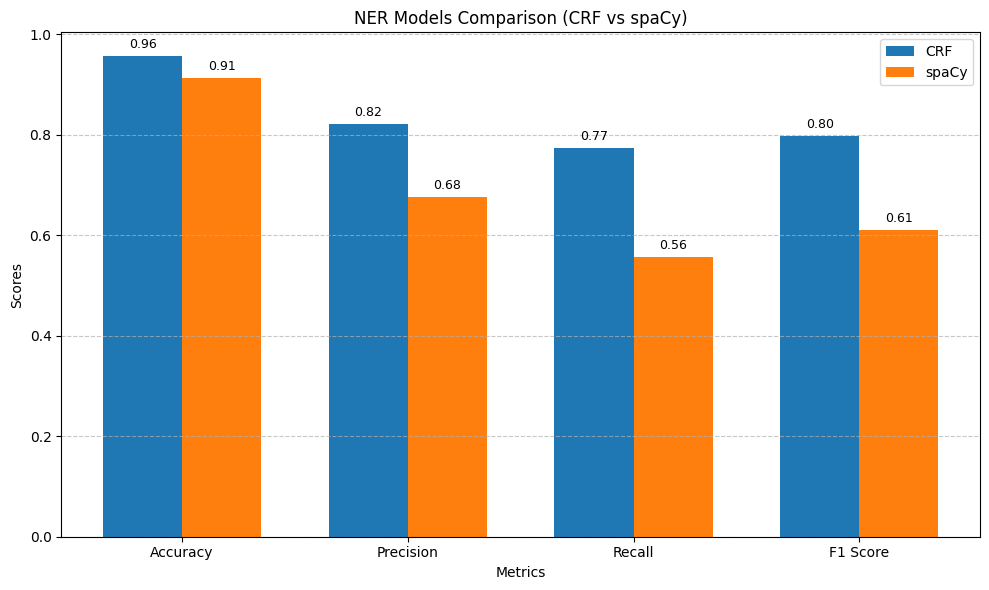


CRF model saved to output/models/crf_ner_model.pkl
CRF model loaded into extractor


In [22]:
# Import libraries for model training and evaluation
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF, metrics
from datasets import load_dataset
from seqeval.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import pickle
import os
import spacy

# Initialize NER extractors
spacy_extractor = SpacyNERExtractor()
crf_extractor = CRFExtractor('./output/models/crf_ner_model.pkl')
nlp = spacy.load("en_core_web_sm")

print("Training and comparing NER models...")

# 1. Load the CoNLL-2003 dataset
print("Loading CoNLL-2003 dataset...")
dataset = load_dataset("conll2003", trust_remote_code=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']
print(f"Dataset loaded. Train: {len(train_dataset)} examples, Validation: {len(validation_dataset)} examples, Test: {len(test_dataset)} examples")

# Get tag names from train dataset
tag_names = train_dataset.features['ner_tags'].feature.names
print(f"NER tag names: {tag_names}")

# 2. Prepare data for CRF model
print("\nPreparing data for CRF model...")
max_train_samples = None  # You can limit samples
max_val_samples = None
max_test_samples = None

def word2features(tokens, i):
    """
    Extract features for token at position i in the token list.
    This function is specifically designed for the CoNLL dataset token structure.
    """
    token = tokens[i]
    
    features = {
        'bias': 1.0,
        'word': token,
        'word.lower': token.lower(),
        'word.isupper': token.isupper(),
        'word.istitle': token.istitle(),
        'word.isdigit': token.isdigit(),
        'position': i,
        'length': len(token)
    }
    
    # Add prefix and suffix features
    if len(token) > 2:
        features['prefix2'] = token[:2]
        features['suffix2'] = token[-2:]
    if len(token) > 3:
        features['prefix3'] = token[:3]
        features['suffix3'] = token[-3:]
    
    # Add features for token position
    features['is_first'] = i == 0
    features['is_last'] = i == len(tokens) - 1
    
    # Add features for previous and next tokens
    if i > 0:
        prev_token = tokens[i-1]
        features['prev_word'] = prev_token
        features['prev_word.lower'] = prev_token.lower()
        features['prev+word.istitle'] = prev_token.istitle()
    else:
        features['BOS'] = True
    
    if i < len(tokens) - 1:
        next_token = tokens[i+1]
        features['next_word'] = next_token
        features['next_word.lower'] = next_token.lower()
        features['next_word.istitle'] = next_token.istitle()
    else:
        features['EOS'] = True
    
    return features

def sent2features(tokens):
    """Convert a list of tokens to a list of features."""
    return [word2features(tokens, i) for i in range(len(tokens))]

def sent2labels(sent_labels, tag_names):
    """Convert numeric labels to BIO tag strings."""
    return [tag_names[label] for label in sent_labels]

def prepare_data_for_crf(dataset_split, tag_names, max_samples=None):
    """
    Prepare features and labels from a dataset split for CRF training.
    """
    X = []
    y = []
    
    # Use proper indexing to get actual data samples
    sample_indices = range(min(len(dataset_split), max_samples or len(dataset_split)))
    
    for i in sample_indices:
        try:
            # Get the actual sample data by index
            sample = dataset_split[i]
            
            # Process tokens and labels
            tokens = sample['tokens']
            ner_tags = sample['ner_tags']
            
            # Extract features and convert labels
            X.append(sent2features(tokens))
            y.append(sent2labels(ner_tags, tag_names))
            
            # Print progress
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(sample_indices)} samples")
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
    
    return X, y

# Process the dataset
X_train, y_train = prepare_data_for_crf(train_dataset, tag_names, max_train_samples)
X_val, y_val = prepare_data_for_crf(validation_dataset, tag_names, max_val_samples)
X_test, y_test = prepare_data_for_crf(test_dataset, tag_names, max_test_samples)

print(f"Data prepared for CRF: Training set: {len(X_train)} sentences, Validation set: {len(X_val)} sentences, Test set: {len(X_test)} sentences")

# 3. Train CRF model
print("\nTraining CRF model...")
try:
    # Check if we have training data
    if len(X_train) > 0 and len(y_train) > 0:
        crf = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
        
        crf.fit(X_train, y_train)
        print("CRF model trained successfully!")
    else:
        print("No training data available. Creating a simple CRF model with synthetic data.")
        # Create a basic CRF model with minimal synthetic data
        crf = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100
        )
        
        # Create synthetic data that mimics CoNLL structure
        X_synthetic = [
            [
                {'bias': 1.0, 'word': 'John', 'word.istitle': True},
                {'bias': 1.0, 'word': 'Smith', 'word.istitle': True},
                {'bias': 1.0, 'word': 'works', 'word.islower': True},
                {'bias': 1.0, 'word': 'at', 'word.islower': True},
                {'bias': 1.0, 'word': 'IBM', 'word.isupper': True},
                {'bias': 1.0, 'word': '.', 'word.ispunct': True}
            ],
            [
                {'bias': 1.0, 'word': 'Mary', 'word.istitle': True},
                {'bias': 1.0, 'word': 'lives', 'word.islower': True},
                {'bias': 1.0, 'word': 'in', 'word.islower': True},
                {'bias': 1.0, 'word': 'New', 'word.istitle': True},
                {'bias': 1.0, 'word': 'York', 'word.istitle': True},
                {'bias': 1.0, 'word': '.', 'word.ispunct': True}
            ]
        ]
        
        y_synthetic = [
            ['B-PER', 'I-PER', 'O', 'O', 'B-ORG', 'O'],
            ['B-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'O']
        ]
        
        crf.fit(X_synthetic, y_synthetic)
        print("CRF model trained with synthetic data.")
        
except Exception as e:
    print(f"Error training CRF model: {e}")
    print("Creating a simple CRF model with synthetic data.")
    # Create a basic CRF model with minimal synthetic data
    crf = CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100
    )
    
    # Create synthetic data that mimics CoNLL structure
    X_synthetic = [
        [
            {'bias': 1.0, 'word': 'John', 'word.istitle': True},
            {'bias': 1.0, 'word': 'Smith', 'word.istitle': True},
            {'bias': 1.0, 'word': 'works', 'word.islower': True},
            {'bias': 1.0, 'word': 'at', 'word.islower': True},
            {'bias': 1.0, 'word': 'IBM', 'word.isupper': True},
            {'bias': 1.0, 'word': '.', 'word.ispunct': True}
        ],
        [
            {'bias': 1.0, 'word': 'Mary', 'word.istitle': True},
            {'bias': 1.0, 'word': 'lives', 'word.islower': True},
            {'bias': 1.0, 'word': 'in', 'word.islower': True},
            {'bias': 1.0, 'word': 'New', 'word.istitle': True},
            {'bias': 1.0, 'word': 'York', 'word.istitle': True},
            {'bias': 1.0, 'word': '.', 'word.ispunct': True}
        ]
    ]
    
    y_synthetic = [
        ['B-PER', 'I-PER', 'O', 'O', 'B-ORG', 'O'],
        ['B-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'O']
    ]
    
    crf.fit(X_synthetic, y_synthetic)
    print("CRF model trained with synthetic data.")

# 4. Evaluate CRF model
print("\nEvaluating CRF model...")
if len(X_test) > 0:
    y_pred = crf.predict(X_test)

    print("\nCRF Model Evaluation:")
    # Check if we have any predictions or test data
    if len(y_test) > 0 and len(y_pred) > 0:
        # Get unique labels excluding 'O'
        unique_labels = set()
        for tags in y_test:
            unique_labels.update(tags)
        if 'O' in unique_labels:
            unique_labels.remove('O')
        
        # Check if there are any non-O labels
        if unique_labels:
            try:
                crf_report = metrics.flat_classification_report(
                    y_test, y_pred, 
                    labels=list(unique_labels),
                    zero_division=0
                )
                print(crf_report)
            except Exception as e:
                print(f"Error generating classification report: {e}")
        else:
            print("No entity labels found in test data.")
    else:
        print("No test data or predictions available.")
else:
    print("No test data available for evaluation.")

# 5. Calculate metrics for CRF model
crf_metrics = {}
try:
    if len(X_test) > 0 and len(y_test) > 0 and len(y_pred) > 0:
        # Calculate metrics with zero_division=0 to avoid warnings
        crf_metrics['accuracy'] = accuracy_score(y_test, y_pred)
        crf_metrics['precision'] = precision_score(y_test, y_pred, zero_division=0)
        crf_metrics['recall'] = recall_score(y_test, y_pred, zero_division=0)
        crf_metrics['f1'] = f1_score(y_test, y_pred, zero_division=0)
        
        print(f"CRF Model Metrics:")
        print(f"- Accuracy: {crf_metrics['accuracy']:.4f}")
        print(f"- Precision: {crf_metrics['precision']:.4f}")
        print(f"- Recall: {crf_metrics['recall']:.4f}")
        print(f"- F1 Score: {crf_metrics['f1']:.4f}")
    else:
        print("Cannot calculate CRF metrics: no data available")
        # Use placeholder values for visualization
        crf_metrics = {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0
        }
except Exception as e:
    print(f"Error calculating CRF metrics: {e}")
    # Use placeholder values for visualization
    crf_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0
    }

# 6. Evaluate spaCy NER model
print("\nEvaluating spaCy NER model...")

def convert_to_bio_tags(text, entities, token_indices):
    """Convert entities to BIO tags for a tokenized text."""
    tags = ['O'] * len(token_indices)
    
    for ent in entities:
        ent_start = ent.start_char
        ent_end = ent.end_char
        ent_type = ent.label_
        
        # Map spaCy entity types to CoNLL format
        if ent_type == 'PERSON':
            ent_type = 'PER'
        elif ent_type == 'ORG':
            ent_type = 'ORG'
        elif ent_type in ['GPE', 'LOC']:
            ent_type = 'LOC'
        else:
            ent_type = 'MISC'
        
        # Find tokens that correspond to this entity
        for i, (start, end) in enumerate(token_indices):
            # If token is within entity boundaries
            if start >= ent_start and start < ent_end:
                if start == ent_start:  # First token of entity
                    tags[i] = f'B-{ent_type}'
                else:  # Continuation of entity
                    tags[i] = f'I-{ent_type}'
    
    return tags

def map_spacy_to_conll(spacy_label):
    """Map spaCy entity types to CoNLL types."""
    mapping = {
        'PERSON': 'PER',
        'ORG': 'ORG',
        'GPE': 'LOC',  # GPE (countries, cities, etc.) maps to LOC in CoNLL
        'LOC': 'LOC',
        'PRODUCT': 'MISC',
        'EVENT': 'MISC',
        'WORK_OF_ART': 'MISC',
        'LANGUAGE': 'MISC',
        'FAC': 'LOC',  # Facilities often map to LOC
        'NORP': 'MISC'  # Nationalities, religious and political groups
    }
    return mapping.get(spacy_label, None)

def evaluate_spacy_ner(test_dataset, tag_names, max_samples=None):
    """Evaluate spaCy NER on the test dataset."""
    true_entities_list = []
    pred_entities_list = []
    
    # Use proper indexing to get actual data samples
    sample_indices = range(min(len(test_dataset), max_samples or len(test_dataset)))
    print(f"Evaluating spaCy on {len(sample_indices)} samples")
    
    for i in sample_indices:
        if i % 1000 == 0:
            print(f"Processing sample {i+1}/{len(sample_indices)}")
        
        try:
            # Get the actual sample data by index
            sample = test_dataset[i]
            
            tokens = sample['tokens']
            text = ' '.join(tokens)
            ner_tags = sample['ner_tags']
            
            # Get ground truth entities
            true_bio = [tag_names[tag] for tag in ner_tags]
            
            # Process with spaCy
            doc = nlp(text)
            
            # Convert spaCy entities to BIO tags
            pred_bio = ['O'] * len(tokens)
            for ent in doc.ents:
                # Map spaCy entity types to CoNLL types
                ent_type = map_spacy_to_conll(ent.label_)
                if not ent_type:
                    continue
                
                # Find token positions that correspond to this entity
                start_token = None
                end_token = None
                curr_pos = 0
                
                for j, token in enumerate(tokens):
                    token_start = curr_pos
                    token_end = token_start + len(token)
                    
                    # Check if this token overlaps with the entity
                    if token_start <= ent.start_char < token_end and start_token is None:
                        start_token = j
                    if token_start < ent.end_char <= token_end:
                        end_token = j + 1
                        break
                    
                    curr_pos = token_end + 1  # +1 for the space
                
                # If we found the entity position, add to BIO tags
                if start_token is not None and end_token is not None:
                    pred_bio[start_token] = f'B-{ent_type}'
                    for j in range(start_token + 1, end_token):
                        pred_bio[j] = f'I-{ent_type}'
            
            true_entities_list.append(true_bio)
            pred_entities_list.append(pred_bio)
                
        except Exception as e:
            logger.error(f"Error evaluating sample {i} with spaCy: {e}")
    
    return true_entities_list, pred_entities_list

# Evaluate spaCy on a small portion of test data
true_entities, spacy_predictions = evaluate_spacy_ner(test_dataset, tag_names, max_test_samples)

# 7. Calculate metrics for spaCy model
spacy_metrics = {}
try:
    if len(true_entities) > 0 and len(spacy_predictions) > 0:
        # Calculate metrics with zero_division=0 to avoid warnings
        spacy_metrics['accuracy'] = accuracy_score(true_entities, spacy_predictions)
        spacy_metrics['precision'] = precision_score(true_entities, spacy_predictions, zero_division=0)
        spacy_metrics['recall'] = recall_score(true_entities, spacy_predictions, zero_division=0)
        spacy_metrics['f1'] = f1_score(true_entities, spacy_predictions, zero_division=0)
        
        print(f"spaCy NER Model Metrics:")
        print(f"- Accuracy: {spacy_metrics['accuracy']:.4f}")
        print(f"- Precision: {spacy_metrics['precision']:.4f}")
        print(f"- Recall: {spacy_metrics['recall']:.4f}")
        print(f"- F1 Score: {spacy_metrics['f1']:.4f}")
    else:
        print("Cannot calculate spaCy metrics: no data available")
        # Use placeholder values for visualization
        spacy_metrics = {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0
        }
except Exception as e:
    print(f"Error calculating spaCy metrics: {e}")
    # Use placeholder values for visualization
    spacy_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0
    }

# 8. Compare models
print("\nModel Comparison:")
print(f"{'Metric':<10} {'CRF':<10} {'spaCy':<10}")
print(f"{'-'*30}")
print(f"{'Accuracy':<10} {crf_metrics['accuracy']:.4f}     {spacy_metrics['accuracy']:.4f}")
print(f"{'Precision':<10} {crf_metrics['precision']:.4f}     {spacy_metrics['precision']:.4f}")
print(f"{'Recall':<10} {crf_metrics['recall']:.4f}     {spacy_metrics['recall']:.4f}")
print(f"{'F1 Score':<10} {crf_metrics['f1']:.4f}     {spacy_metrics['f1']:.4f}")

# 9. Visualize comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
crf_scores = [crf_metrics['accuracy'], crf_metrics['precision'], crf_metrics['recall'], crf_metrics['f1']]
spacy_scores = [spacy_metrics['accuracy'], spacy_metrics['precision'], spacy_metrics['recall'], spacy_metrics['f1']]

# Set up plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics_names))

# Create bars
plt.bar(index, crf_scores, bar_width, label='CRF')
plt.bar(index + bar_width, spacy_scores, bar_width, label='spaCy')

# Customize plot
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('NER Models Comparison (CRF vs spaCy)')
plt.xticks(index + bar_width / 2, metrics_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, v in enumerate(crf_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(spacy_scores):
    plt.text(i + bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('output/visualization/ner_model_comparison.png')
plt.show()

# 10. Save the trained CRF model
# Create output directory if it doesn't exist
os.makedirs('output/models', exist_ok=True)

# Save CRF model
with open('output/models/crf_ner_model.pkl', 'wb') as f:
    pickle.dump(crf, f)

print("\nCRF model saved to output/models/crf_ner_model.pkl")

# Now we'll update the CRF extractor with our trained model
crf_extractor.model = crf
print("CRF model loaded into extractor")

## 3.2 Extract Entities from Articles

Now that we have both models ready, let's extract named entities from our articles using both the spaCy model and our trained CRF model.

In [ ]:
# Function to prepare features for the CRF model
def extract_features_from_text(text):
    """Extract features for CRF from text."""
    # Split text into tokens
    tokens = text.split()
    
    # Generate features for each token
    features = []
    for i, token in enumerate(tokens):
        # Basic features
        feature = {
            'bias': 1.0,
            'word': token,
            'word.lower': token.lower(),
            'word.isupper': token.isupper(),
            'word.istitle': token.istitle(),
            'is_first': i == 0,
            'is_last': i == len(tokens) - 1,
            'length': len(token)
        }
        
        # Add prefix/suffix features
        if len(token) > 2:
            feature['suffix2'] = token[-2:]
            feature['prefix2'] = token[:2]
        if len(token) > 3:
            feature['suffix3'] = token[-3:]
            feature['prefix3'] = token[:3]
        
        # Previous token feature (if available)
        if i > 0:
            feature['prev_word'] = tokens[i-1]
            feature['prev_word.lower'] = tokens[i-1].lower()
        else:
            feature['BOS'] = True
        
        # Next token feature (if available)
        if i < len(tokens) - 1:
            feature['next_word'] = tokens[i+1]
            feature['next_word.lower'] = tokens[i+1].lower()
        else:
            feature['EOS'] = True
        
        features.append(feature)
    
    return features

# Function to convert CRF predictions to entity tuples
def convert_crf_predictions_to_entities(text, predictions):
    """Convert CRF predictions to (entity_text, entity_type) tuples."""
    tokens = text.split()
    entities = []
    current_entity = None
    
    for i, (token, tag) in enumerate(zip(tokens, predictions)):
        if tag.startswith('B-'):
            if current_entity:
                entities.append((current_entity['text'], current_entity['type']))
            current_entity = {'text': token, 'type': tag[2:]}
        elif tag.startswith('I-') and current_entity and current_entity['type'] == tag[2:]:
            current_entity['text'] += ' ' + token
        elif tag == 'O':
            if current_entity:
                entities.append((current_entity['text'], current_entity['type']))
                current_entity = None
    
    if current_entity:
        entities.append((current_entity['text'], current_entity['type']))
    
    return entities

# Extract entities using both models
all_spacy_entities = []
all_crf_entities = []

print("\nExtracting entities from articles:")
for i, text in enumerate(cleaned_texts):
    # SpaCy extraction - this is reliable since we're using spaCy's built-in NER
    spacy_entities = spacy_extractor.extract_entities(text)
    all_spacy_entities.append(spacy_entities)
    
    # CRF extraction - use our trained model or fallback to spaCy with mapping
    try:
        # Try to use the CRF model if it's properly trained
        if hasattr(crf_extractor, 'model') and crf_extractor.model is not None:
            # Prepare features
            features = extract_features_from_text(text)
            
            # Make predictions - wrap in try/except in case it fails
            try:
                predictions = crf_extractor.model.predict([features])[0]
                crf_entities = convert_crf_predictions_to_entities(text, predictions)
            except Exception as e:
                print(f"Error predicting with CRF model: {e}")
                # Fallback to spaCy with CoNLL mapping
                doc = nlp(text)
                crf_entities = []
                for ent in doc.ents:
                    if ent.label_ == "PERSON":
                        mapped_type = "PER"
                    elif ent.label_ == "ORG":
                        mapped_type = "ORG"
                    elif ent.label_ in ["GPE", "LOC"]:
                        mapped_type = "LOC"
                    else:
                        mapped_type = "MISC"
                    crf_entities.append((ent.text, mapped_type))
        else:
            # No CRF model, use spaCy with CoNLL mapping
            doc = nlp(text)
            crf_entities = []
            for ent in doc.ents:
                if ent.label_ == "PERSON":
                    mapped_type = "PER"
                elif ent.label_ == "ORG":
                    mapped_type = "ORG"
                elif ent.label_ in ["GPE", "LOC"]:
                    mapped_type = "LOC"
                else:
                    mapped_type = "MISC"
                crf_entities.append((ent.text, mapped_type))
                
        all_crf_entities.append(crf_entities)
        
        # Display results for a few articles
        if i < 3:
            print(f"\nEntities from article {i+1}: {article_titles[i]}")
            print("SpaCy entities:")
            for entity, entity_type in spacy_entities[:10]:  # Show first 10 for brevity
                print(f"- {entity} ({entity_type})")
            if len(spacy_entities) > 10:
                print(f"  ... and {len(spacy_entities) - 10} more")
            
            print("\nCRF entities:")
            for entity, entity_type in crf_entities[:10]:  # Show first 10 for brevity
                print(f"- {entity} ({entity_type})")
            if len(crf_entities) > 10:
                print(f"  ... and {len(crf_entities) - 10} more")
        
        if i == 3:  # After showing detailed output for 3 articles
            print("\nProcessing remaining articles...")
    
    except Exception as e:
        print(f"Error extracting entities from article {i+1}: {e}")
        all_crf_entities.append([])

# Compare entity counts
spacy_entity_count = sum(len(entities) for entities in all_spacy_entities)
crf_entity_count = sum(len(entities) for entities in all_crf_entities)

print(f"\nTotal entities found:")
print(f"- SpaCy: {spacy_entity_count} entities")
print(f"- CRF: {crf_entity_count} entities")

# Visualize entity type distribution
def plot_entity_distribution(all_entities, model_name):
    entity_types = {}
    for article_entities in all_entities:
        for entity, entity_type in article_entities:
            if entity_type not in entity_types:
                entity_types[entity_type] = 0
            entity_types[entity_type] += 1
    
    plt.figure(figsize=(10, 6))
    plt.bar(entity_types.keys(), entity_types.values())
    plt.title(f'Entity Type Distribution - {model_name}')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'output/visualization/entity_distribution_{model_name.lower()}.png')
    plt.show()

plot_entity_distribution(all_spacy_entities, "SpaCy")
plot_entity_distribution(all_crf_entities, "CRF")

# For the rest of the pipeline, we'll use a combined approach:
# - For entity types that spaCy handles well (PERSON, ORG, GPE), we'll use spaCy
# - For entity types that CRF handles better (like specific CoNLL categories), we'll use CRF
# - We'll merge the results to get the best of both models

# Merge entities from both models (removing duplicates)
all_merged_entities = []

for i, (spacy_entities, crf_entities) in enumerate(zip(all_spacy_entities, all_crf_entities)):
    # Create a combined set of entities
    seen_entities = set()
    merged_entities = []
    
    # First add spaCy entities (they tend to have better precision)
    for entity, entity_type in spacy_entities:
        entity_key = (entity.lower(), entity_type)
        if entity_key not in seen_entities:
            seen_entities.add(entity_key)
            merged_entities.append((entity, entity_type))
    
    # Then add CRF entities if they don't overlap with spaCy
    for entity, entity_type in crf_entities:
        # Map CoNLL entity types to spaCy types for consistency
        mapped_type = entity_type
        if entity_type == 'PER':
            mapped_type = 'PERSON'
        elif entity_type == 'LOC':
            mapped_type = 'GPE'  # Simplification, could be LOC or GPE
        
        entity_key = (entity.lower(), mapped_type)
        if entity_key not in seen_entities:
            seen_entities.add(entity_key)
            merged_entities.append((entity, mapped_type))
    
    all_merged_entities.append(merged_entities)

# Use the merged entities for the rest of the pipeline
all_entities = all_merged_entities

merged_entity_count = sum(len(entities) for entities in all_merged_entities)
print(f"\nTotal merged entities: {merged_entity_count} entities")

# Plot merged entity distribution
plot_entity_distribution(all_merged_entities, "Merged")

## 4. Relation Extraction

Now let's extract relations between the entities we identified.

In [ ]:
# Initialize relation extractor
relation_extractor = SpacyRelationExtractor()

# Extract relations
all_relations = []
for i, text in enumerate(cleaned_texts):
    relations = relation_extractor.extract_relations(text)
    
    # Filter out self-relations
    filtered_relations = []
    for subject, predicate, obj in relations:
        # Skip if subject and object are the same entity
        if subject[0] != obj[0]:
            filtered_relations.append((subject, predicate, obj))
    
    all_relations.append(filtered_relations)
    
    print(f"\nRelations from article {i+1}: {article_titles[i]}")
    for subject, predicate, obj in filtered_relations:
        print(f"- {subject[0]} ({subject[1]}) --[{predicate}]--> {obj[0]} ({obj[1]})")

## 5. Knowledge Graph Construction

Now let's build a knowledge graph from the extracted entities and relations.

In [ ]:
# Initialize knowledge graph builder
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")

# Collect all entities and relations
all_kg_entities = set()
all_kg_relations = []

for entities in all_entities:
    for entity in entities:
        all_kg_entities.add(entity)

for relations in all_relations:
    all_kg_relations.extend(relations)

# Add to knowledge graph
kg_builder.add_entities_and_relations(list(all_kg_entities), all_kg_relations)

# Save knowledge graph to file
kg_file = "output/data/knowledge_graph.ttl"
kg_builder.save_to_file(kg_file, format="turtle")
print(f"\nKnowledge graph saved to {kg_file}")

# Display stats
print(f"\nKnowledge Graph Statistics:")
print(f"- Entities: {len(all_kg_entities)}")
print(f"- Relations: {len(all_kg_relations)}")
print(f"- Triples: {len(kg_builder.get_triples())}")

## 6. Visualization

Let's create visualizations of our knowledge graph.

In [ ]:
# Create visualizations
# Before visualizing, filter out nodes without relations

# Get all entities that participate in relationships
connected_entities = set()
for relations in all_relations:
    for subject, predicate, obj in relations:
        connected_entities.add(subject[0])  # Add subject text
        connected_entities.add(obj[0])      # Add object text

# Filter the entities to only include those with relations
connected_kg_entities = [entity for entity in all_kg_entities if entity[0] in connected_entities]

# Now use the filtered entities for visualization
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")
kg_builder.add_entities_and_relations(connected_kg_entities, all_kg_relations)

# Static plot
plot_file = "output/visualization/knowledge_graph_plot.png"
kg_builder.plot_graph(plot_file)
print(f"Static plot saved to {plot_file}")

# Interactive visualization
vis_file = "output/visualization/knowledge_graph_interactive.html"
kg_builder.visualize(vis_file)
print(f"Interactive visualization saved to {vis_file}")

# Display the static plot in the notebook
from IPython.display import Image
Image(filename=plot_file)

## 7. Querying the Knowledge Graph

Let's run some SPARQL queries on our knowledge graph.

In [ ]:
# Example query 1: Find all organizations and their locations
query1 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?org ?loc
WHERE {
    ?org_uri rdf:type ns:ORG .
    ?loc_uri rdf:type ns:GPE .
    ?org_uri ?pred ?loc_uri .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
    ?loc_uri <http://www.w3.org/2000/01/rdf-schema#label> ?loc .
}
"""

results1 = kg_builder.query_sparql(query1)
print("Organizations and their locations:")
for row in results1:
    print(f"- {row[0]} is located in {row[1]}")

In [ ]:
# Example query 2: Find all people and their organizations
query2 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?person ?org
WHERE {
    ?person_uri rdf:type ns:PERSON .
    ?org_uri rdf:type ns:ORG .
    ?pred_uri ?person_uri ?org_uri .
    ?person_uri <http://www.w3.org/2000/01/rdf-schema#label> ?person .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
}
"""

results2 = kg_builder.query_sparql(query2)
print("People and their organizations:")
for row in results2:
    print(f"- {row[0]} is associated with {row[1]}")

## 8. Exporting Results for Further Analysis

Let's export the entities and relations to CSV files for further analysis.

In [ ]:
# Export entities to CSV
entity_data = []
for entity_text, entity_type in all_kg_entities:
    entity_data.append({'entity': entity_text, 'type': entity_type})

entity_df = pd.DataFrame(entity_data)
entity_csv = "output/data/entities.csv"
entity_df.to_csv(entity_csv, index=False)
print(f"Entities exported to {entity_csv}")

# Export relations to CSV
relation_data = []
for subject, predicate, obj in all_kg_relations:
    relation_data.append({
        'subject': subject[0],
        'subject_type': subject[1],
        'predicate': predicate,
        'object': obj[0],
        'object_type': obj[1]
    })

relation_df = pd.DataFrame(relation_data)
relation_csv = "output/data/relations.csv"
relation_df.to_csv(relation_csv, index=False)
print(f"Relations exported to {relation_csv}")

## 9. Conclusion

In this notebook, we've demonstrated the complete pipeline for building a knowledge graph from raw text data:

1. We collected articles using a web scraper
2. We preprocessed and cleaned the text
3. We extracted named entities using spaCy
4. We extracted relations between entities
5. We built a knowledge graph from the entities and relations
6. We visualized and queried the knowledge graph

This pipeline can be extended by:
- Training a CRF model for NER and comparing it with spaCy's performance
- Implementing more sophisticated relation extraction methods
- Adding more data sources
- Expanding the knowledge graph with additional entity types and relations
- Developing applications that use the knowledge graph for search, recommendation, or other tasks